In [1]:
from glob import glob
import numpy as np
from astropy.table import QTable, vstack
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')
plt.style.use('paper')

In [2]:
def custom_sort(arr):
    def key_func(item):
        num = int(item[4:])  # 'conf' has length 4
        return (num == 10, num)
    return sorted(arr, key=key_func)

def get_mrs(ratio_arr, wide_arr, n=100000, ymin=0.499, ymax=0.501, skip=0):

    wide_arr_ = wide_arr.copy()

    ratio_arr[(ratio_arr>1) | (ratio_arr<0)] = np.nan

    mask = np.isfinite(ratio_arr)
    ratio_arr = ratio_arr[mask]
    wide_arr_ = wide_arr_[mask]

    f = interp1d(wide_arr_[skip:], ratio_arr[skip:], fill_value="extrapolate")

    xarr_m = []
    factor = 1 
    while len(xarr_m)<1:
        factor += 0.1
        xarr = np.linspace(0,np.nanmax(wide_arr)*factor, n)
        farr = f(xarr)
        xarr_m = xarr[(farr>ymin)&(farr<ymax)]  

    stats1 = np.percentile(xarr_m, [0,50,100])
    stats2 = np.nanmean(xarr_m)

    stats = {'min':stats1[0],'med':stats1[1],'max':stats1[2],'mean':stats2}

    return(stats)

def get_mrs_baseline(baseline, f=0.983):
    theta_mrs = f * (3e8/100e9) / np.array(baseline)
    theta_mrs = theta_mrs * u.radian
    return(theta_mrs.to('arcsec').value)

In [3]:
which = 'gaussians'
version = '_gaussians_v4'

which_times = ['_6totaltime', '_6totaltime_flagged', '_60totaltime', '_60totaltime_flagged', 
               '_6totaltime_noise', '_6totaltime_flagged_noise', '_60totaltime_noise', '_60totaltime_flagged_noise']

# which_times = ['_60totaltime_noise']

min_baseline =  [8.7, 14.6, 14.6, 14.6, 14.6, 14.6, 14.6, 64.0, 110.4, 367.6, 244.0]
min_baseline5 = [9.1, 21.4, 27.0, 37.6, 54.1, 90.9, 148.6, 235.2, 427.3, 746.9, 1228.1]
mrs_size   =       get_mrs_baseline(min_baseline)
mrs_size5_ =      [66.7, 28.5, 22.6, 16.2, 11.2, 6.7, 4.11, 2.58, 1.42, 0.814, 0.496]
mrs_size5 =      get_mrs_baseline(min_baseline5)
beam_size =     [12.5, 3.38, 2.3, 1.42, 0.918, 0.545, 0.306, 0.211, 0.096, 0.057, 0.042]
configuration = ['conf0', 'conf1', 'conf2', 'conf3', 'conf4', 'conf5', 'conf6', 'conf7', 'conf8', 'conf9', 'conf10']
mrs_conf = np.arange(0,11)
tables = {}

for which_time in which_times: 

    table = vstack([QTable.read(file) for file in glob(f'../data/tables{version}/table_fit_{which}{which_time}_conf*.fits')])
    conf_unique = np.unique(table['conf']) 
    conf_unique =  custom_sort(conf_unique)
    conf_unique_ = np.unique(table['conf_']) 

    print('%s %s' %(which_time, conf_unique))

    table.sort('conf')
    tables[which_time] = table
    print(table.colnames)

_6totaltime ['conf0', 'conf1', 'conf2', 'conf3', 'conf4', 'conf5', 'conf6', 'conf7', 'conf8', 'conf9', 'conf10']
['conf', 'wide', 'sum_sim', 'sum_obs', 'rms_obs', 'max_sim', 'max_obs', 'sum_fit_sim', 'sum_fit_obs', 'errl_fit_sim', 'errh_fit_sim', 'errl_fit_obs', 'errh_fit_obs', 'sum_mask10_sim', 'sum_mask10_obs', 'sum_mask50_sim', 'sum_mask50_obs', 'rchi2_sim', 'rchi2_obs', 'conf_', 'wide_']
_6totaltime_flagged ['conf0', 'conf1', 'conf2', 'conf3', 'conf4', 'conf5', 'conf6', 'conf7', 'conf8', 'conf9', 'conf10']
['conf', 'wide', 'sum_sim', 'sum_obs', 'rms_obs', 'max_sim', 'max_obs', 'sum_fit_sim', 'sum_fit_obs', 'errl_fit_sim', 'errh_fit_sim', 'errl_fit_obs', 'errh_fit_obs', 'sum_mask10_sim', 'sum_mask10_obs', 'sum_mask50_sim', 'sum_mask50_obs', 'rchi2_sim', 'rchi2_obs', 'conf_', 'wide_']
_60totaltime ['conf0', 'conf1', 'conf2', 'conf3', 'conf4', 'conf5', 'conf6', 'conf7', 'conf8', 'conf9', 'conf10']
['conf', 'wide', 'sum_sim', 'sum_obs', 'rms_obs', 'max_sim', 'max_obs', 'sum_fit_sim', '

In [4]:
min_baseline =  [8.7, 14.6, 14.6, 14.6, 14.6, 14.6, 14.6, 64.0, 110.4, 367.6, 244.0]
min_baseline5 = [9.1, 21.4, 27.0, 37.6, 54.1, 90.9, 148.6, 235.2, 427.3, 746.9, 1228.1]

array([69.91665674, 41.66266532, 41.66266532, 41.66266532, 41.66266532,
       41.66266532, 41.66266532,  9.50429553,  5.50973654,  1.65471957,
        2.49292997])

In [33]:
tables_mrs = {}
for which_time in which_times: 
	print(which_time)

	table = tables[which_time] 
	conf_unique = np.unique(table['conf']) 
	conf_unique = custom_sort(conf_unique)
	conf_unique_ = np.unique(table['conf_']) 
	
	# Get ratio 50percent for table
	ratio_fit_50percent_arr = np.ones(len(conf_unique))
	ratio_fiterrl_50percent_arr = np.ones(len(conf_unique))
	ratio_fiterrh_50percent_arr = np.ones(len(conf_unique))
	ratio_mask10_50percent_arr = np.ones(len(conf_unique))

	for i, conf in enumerate(conf_unique):

		# if i!=1:
		# 	continue

		if 'noise' in which_time:
			model_f = 15000
			if '60' in which_time:
				model_f = model_f*np.sqrt(10)
		else: 
			model_f  = 1
		
		if model_f!=1:  
			if conf == 'conf0':
				model_f_ = model_f/15
			else: 
				model_f_ = model_f
		else:
			model_f_ = model_f


		conf_tab = table[np.where(table['conf']==conf)]
		conf_arr = conf_tab['conf']
		wide_arr = [''] * len(conf_arr)

		sum_sim = conf_tab['sum_sim'].value/model_f_
		sum_obs = conf_tab['sum_obs'].value
		sum_fit_sim = conf_tab['sum_fit_sim'].value/model_f_
		sum_fit_obs = conf_tab['sum_fit_obs'].value
		errl_fit_sim = conf_tab['errl_fit_sim'].value/model_f_ 
		errh_fit_sim = conf_tab['errh_fit_sim'].value/model_f_
		errl_fit_obs = conf_tab['errl_fit_obs'].value 
		errh_fit_obs = conf_tab['errh_fit_obs'].value 
		sum_mask10_obs = conf_tab['sum_mask10_obs'].value
		sum_mask10_sim = conf_tab['sum_mask10_sim'].value/model_f_
		sum_mask50_obs = conf_tab['sum_mask50_obs'].value
		sum_mask50_sim = conf_tab['sum_mask50_sim'].value/model_f_
		ratio_arr = sum_obs/sum_sim
		ratio_fit_arr = sum_fit_obs/sum_fit_sim
		ratio_mask10_arr = sum_mask10_obs/sum_mask10_sim
		ratio_mask50_arr = sum_mask50_obs/sum_mask50_sim
		ratio_fiterrl_arr = errl_fit_obs/errl_fit_sim
		ratio_fiterrh_arr = errh_fit_obs/errh_fit_sim

		ferrh = np.abs(np.abs(errh_fit_obs-sum_fit_obs)/sum_fit_obs)
		ferrl = np.abs(np.abs(errl_fit_obs-sum_fit_obs)/sum_fit_obs)
		ratio_fiterrl_arr = np.abs(ratio_fit_arr*ferrl)
		ratio_fiterrh_arr = np.abs(ratio_fit_arr*ferrh)

		for j, wide in enumerate(conf_tab['wide']):
			wide_arr[j] = float(wide.replace('mrs0',''))
		wide_arr = np.array(wide_arr)

		ids = np.argsort(wide_arr)
		wide_arr = wide_arr[ids]
		ratio_fit_arr = ratio_fit_arr[ids]
		ratio_arr = ratio_arr[ids]
		ratio_mask10_arr = ratio_mask10_arr[ids]
		ratio_mask50_arr = ratio_mask50_arr[ids]

		mask1 = ratio_fiterrl_arr/ratio_fit_arr < 50
		mask2 = ratio_fiterrh_arr/ratio_fit_arr < 50

		ratio_fit_arr[0] = 1
		ratio_fit_arr[1] = 1
		ratio_fiterrl_arr[0] = 0
		ratio_fiterrh_arr[0] = 0

		ratio_fit_50percent_arr[i] = get_mrs(ratio_fit_arr, wide_arr, skip=0)['mean']
		ratio_fiterrl_50percent_arr[i] = get_mrs((ratio_fit_arr-ratio_fiterrl_arr)[mask1], wide_arr[mask1], skip=0)['min']
		ratio_fiterrh_50percent_arr[i] = get_mrs((ratio_fit_arr+ratio_fiterrh_arr)[mask2], wide_arr[mask2], skip=0)['max']
		ratio_mask10_50percent_arr[i] = get_mrs(ratio_mask10_arr, wide_arr, skip=0)['mean']

	data = [conf_unique, conf_unique_, ratio_fit_50percent_arr, ratio_fiterrl_50percent_arr, ratio_fiterrh_50percent_arr, ratio_mask10_50percent_arr]
	names = ['conf', 'conf_', 'ratio_fit_50percent', 'ratio_fiterrl_50percent', 'ratio_fiterrh_50percent', 'ratio_mask10_50percent']

	tables_mrs[which_time] = QTable(data, names=names)
tables_mrs.keys()

_6totaltime
_6totaltime_flagged
_60totaltime
_60totaltime_flagged
_6totaltime_noise
_6totaltime_flagged_noise
_60totaltime_noise
_60totaltime_flagged_noise


dict_keys(['_6totaltime', '_6totaltime_flagged', '_60totaltime', '_60totaltime_flagged', '_6totaltime_noise', '_6totaltime_flagged_noise', '_60totaltime_noise', '_60totaltime_flagged_noise'])

In [34]:
tables_mrs['_6totaltime_comb'] = vstack([tables_mrs['_6totaltime'][:4], tables_mrs[ '_6totaltime_flagged'][4:]])
tables_mrs['_60totaltime_comb'] = vstack([tables_mrs['_60totaltime'][:4], tables_mrs[ '_60totaltime_flagged'][4:]])
tables_mrs['_6totaltime_noise_comb'] = vstack([tables_mrs['_6totaltime_noise'][:4], tables_mrs[ '_6totaltime_flagged_noise'][4:]])
tables_mrs['_60totaltime_noise_comb'] = vstack([tables_mrs['_60totaltime_noise'][:4], tables_mrs[ '_60totaltime_flagged_noise'][4:]])

which_times = ['_6totaltime_comb', '_60totaltime_comb', '_6totaltime_noise_comb', '_60totaltime_noise_comb']

In [35]:
table_6totaltime_comb = tables_mrs['_6totaltime_comb'].copy()
table_60totaltime_comb = tables_mrs['_60totaltime_comb'].copy()
table_6totaltime_noise_comb = tables_mrs['_6totaltime_noise_comb'].copy()
table_60totaltime_noise_comb = tables_mrs['_60totaltime_noise_comb'].copy()

def get_pubtable(table):

    table.rename_column('conf_', 'conf_float')
    table.rename_column('ratio_fit_50percent', 'mrs')
    table.rename_column('ratio_fiterrh_50percent', 'mrs_errh')
    table.rename_column('ratio_fiterrl_50percent', 'mrs_errl')
    table.remove_column('ratio_mask10_50percent')

    table['mrs'] = table['mrs'] *u.arcsec
    table['mrs_errh'] = table['mrs_errh'] *u.arcsec
    table['mrs_errl'] = table['mrs_errl'] *u.arcsec

    table['mrs_errh'] = table['mrs_errh'] - table['mrs'] 
    table['mrs_errl'] = table['mrs'] - table['mrs_errl']
    table['mrs_err20'] = 0.2*table['mrs']

    return(table)

table_6totaltime_comb = get_pubtable(table_6totaltime_comb)
table_60totaltime_comb = get_pubtable(table_60totaltime_comb)
table_6totaltime_noise_comb = get_pubtable(table_6totaltime_noise_comb)
table_60totaltime_noise_comb = get_pubtable(table_60totaltime_noise_comb)

table_6totaltime_comb.write(f'../data/tables{version}/table_{which}_6totaltime_final.fits', overwrite=True)
table_60totaltime_comb.write(f'../data/tables{version}/table_{which}_60totaltime_final.fits', overwrite=True)
table_6totaltime_noise_comb.write(f'../data/tables{version}/table_{which}_6totaltime_noise_final.fits', overwrite=True)
table_60totaltime_noise_comb.write(f'../data/tables{version}/table_{which}_60totaltime_noise_final.fits', overwrite=True)

table_6totaltime_comb.write(f'../data/tables{version}/table_{which}_6totaltime_final.csv', overwrite=True)
table_60totaltime_comb.write(f'../data/tables{version}/table_{which}_60totaltime_final.csv', overwrite=True)
table_6totaltime_noise_comb.write(f'../data/tables{version}/table_{which}_6totaltime_noise_final.csv', overwrite=True)
table_60totaltime_noise_comb.write(f'../data/tables{version}/table_{which}_60totaltime_noise_final.csv', overwrite=True)

In [36]:
table_6totaltime_comb

conf,conf_float,mrs,mrs_errl,mrs_errh,mrs_err20
,,arcsec,arcsec,arcsec,arcsec
str6,float64,float64,float64,float64,float64
conf0,0.0,35.48633396333963,2.582229622296225,2.2880415804158076,7.097266792667927
conf1,1.0,28.09856658566586,0.5724985249852566,0.6002760027600225,5.619713317133172
conf2,2.0,28.530765307653073,0.3305049050490467,0.32768007680077105,5.706153061530615
conf3,3.0,30.527683476834767,0.42490124901248905,0.42395963959639715,6.105536695366954
conf4,4.0,15.06881088810888,0.15889658896588976,0.16313383133831394,3.0137621776217762
conf5,5.0,9.858179781797817,0.006970769707695723,0.00870438704387233,1.9716359563595636
conf6,6.0,7.978491984919849,0.02000920009200069,-0.5906245062450619,1.5956983969839698
conf7,7.0,3.807641876418764,0.05972179721797177,0.06748347483474904,0.7615283752837528


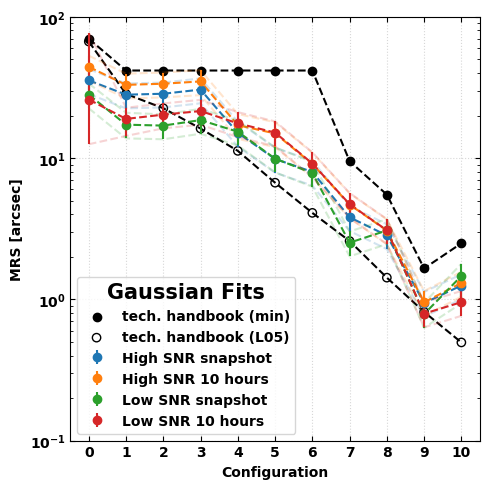

In [37]:
fig1, ax1 = plt.subplots(1,1, figsize=(5, 5))

ax1.plot(mrs_conf, mrs_size, c='k', ls='--')
ax1.scatter(mrs_conf, mrs_size, c='k', label='tech. handbook (min)')

ax1.plot(mrs_conf, mrs_size5, c='k', ls='--')
ax1.scatter(mrs_conf, mrs_size5, ec='k', fc='none', label='tech. handbook (L05)')

for i, which_time in enumerate(list(which_times)):

    table = tables_mrs[which_time] 

    conf = np.array(table['conf_'])
    r_mask10 = np.array(table['ratio_mask10_50percent'])
    r_fit = np.array(table['ratio_fit_50percent'])
    r_fitl = np.array(table['ratio_fiterrl_50percent'])
    r_fith = np.array(table['ratio_fiterrh_50percent'])

    # Make label 
    time = which_time.split('totaltime')[0].split('_')[-1]
    if time == '6': 
        time = 'snapshot'
    else: 
        time = '10 hours'
    label = which_time.split('totaltime')[-1]
    label = label.replace('_', '')
    label = label.replace('comb', '')
    if 'noise' in label:
        label=label.replace('noise', 'Low SNR')
    else: 
        label='%sHigh SNR' %(label)
    #

    yerr = np.abs(np.array([r_fit-r_fitl, r_fit-r_fith]))
    threshold = r_fit * 0.2
    yerr[0][yerr[0] < threshold] = threshold[yerr[0] < threshold]
    yerr[1][yerr[1] < threshold] = threshold[yerr[1] < threshold]

    if 'noise' in label:
        ax1.errorbar(conf, r_fit, yerr=yerr, fmt='o', label='%s %s' %(label, time), color='C%i'%i)
        # ax1.errorbar(conf, r_fit, yerr=r_fit*0.2, fmt='o', color='C%i'%i)
        ax1.plot(conf, r_fit, ls='--', c='C%i'%i)
        ax1.plot(conf, r_fit-yerr[0], ls='--', c='C%i'%i, alpha=0.2)
        ax1.plot(conf, r_fit+yerr[1], ls='--', c='C%i'%i, alpha=0.2)
    else: 
        ax1.errorbar(conf, r_fit, yerr=yerr, fmt='o', label='%s %s' %(label, time), color='C%i'%i)
        # ax1.errorbar(conf, r_fit, yerr=r_fit*0.2, fmt='o', color='C%i'%i)
        ax1.plot(conf, r_fit, ls='--', c='C%i'%i)
        ax1.plot(conf, r_fit-yerr[0], ls='--', c='C%i'%i, alpha=0.2)
        ax1.plot(conf, r_fit+yerr[1], ls='--', c='C%i'%i, alpha=0.2)


ax1.set_ylim([0.1, 1e2])
ax1.set_xlim([-0.5,10.5])
ax1.set_xlabel('Configuration')
ax1.set_ylabel('MRS [arcsec]')
ax1.grid(True, ls=':', alpha=0.5)
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.set_yscale('log')

ax1.legend(loc='lower left', fontsize=10, title='Gaussian Fits', title_fontsize=15)
fig1.tight_layout()
fig1.savefig(f'./../figs/mrs_fit_{which}.pdf', dpi=300, bbox_inches='tight', transparent=False)
fig1.savefig(f'./../figs/mrs_fit_{which}.png', dpi=300, bbox_inches='tight', transparent=False)

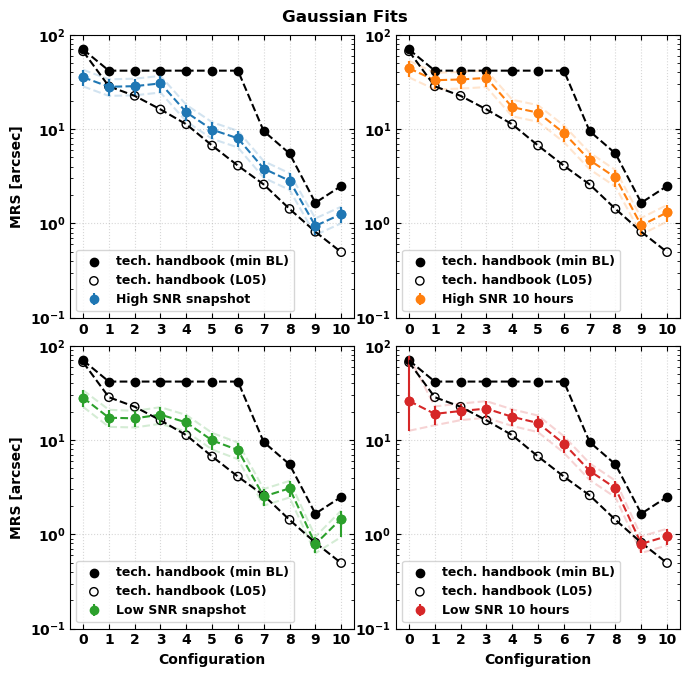

In [38]:
fig1, ax = plt.subplots(2, 2, figsize=(7,7))
ax = ax.flatten()

for i, which_time in enumerate(list(which_times)):
    
    table = tables_mrs[which_time] 

    conf = np.array(table['conf_'])
    r_mask10 = np.array(table['ratio_mask10_50percent'])
    r_fit = np.array(table['ratio_fit_50percent'])
    r_fitl = np.array(table['ratio_fiterrl_50percent'])
    r_fith = np.array(table['ratio_fiterrh_50percent'])

    # Make label 
    time = which_time.split('totaltime')[0].split('_')[-1]
    if time == '6': 
        time = 'snapshot'
    else: 
        time = '10 hours'
    label = which_time.split('totaltime')[-1]
    label = label.replace('_', '')
    label = label.replace('comb', '')
    if 'noise' in label:
        label=label.replace('noise', 'Low SNR')
    else: 
        label='%sHigh SNR' %(label)
    #

    yerr = np.abs(np.array([r_fit-r_fitl, r_fit-r_fith]))
    threshold = r_fit * 0.2
    yerr[0][yerr[0] < threshold] = threshold[yerr[0] < threshold]
    yerr[1][yerr[1] < threshold] = threshold[yerr[1] < threshold]
    
    ax[i].errorbar(conf, r_fit, yerr=yerr, fmt='o', label='%s %s' %(label, time), color='C%i'%i)
    ax[i].plot(conf, r_fit, ls='--', c='C%i'%i)
    ax[i].errorbar(conf, r_fit, yerr=r_fit*0.2, fmt='o', color='C%i'%i)

    ax[i].plot(conf, r_fit-yerr[0], ls='--', c='C%i'%i, alpha=0.2)
    ax[i].plot(conf, r_fit+yerr[1], ls='--', c='C%i'%i, alpha=0.2)

    ax[i].plot(mrs_conf, mrs_size, c='k', ls='--')
    ax[i].scatter(mrs_conf, mrs_size, c='k', label='tech. handbook (min BL)')

    ax[i].plot(mrs_conf, mrs_size5, c='k', ls='--')
    ax[i].scatter(mrs_conf, mrs_size5, ec='k', fc='none', label='tech. handbook (L05)')


for ax_ in ax: 
    ax_.grid(True, ls=':', alpha=0.5)
    ax_.xaxis.set_major_locator(MultipleLocator(1))
    ax_.yaxis.set_minor_locator(MultipleLocator(1))
    ax_.set_ylim([-1,30])
    ax_.set_xlim([-0.5,10.5])
    ax_.legend(loc='upper right', fontsize=9)

# ax[0].text(0.05, 0.12, 'Gaussian', ha='left', transform=ax[0].transAxes, fontsize=11)
# ax[0].text(0.05, 0.05, 'Fit', ha='left', transform=ax[0].transAxes, fontsize=9)
fig1.suptitle('Gaussian Fits', fontweight='bold', y=0.96)

ax[0].set_ylabel('MRS [arcsec]')
ax[2].set_ylabel('MRS [arcsec]')

for ax_ in ax: 
    ax_.set_yscale('log')
    ax_.set_ylim([0.1, 1e2])
    ax_.legend(loc='lower left', fontsize=9)

for i in [2,3]:
    ax[i].set_xlabel('Configuration')

fig1.tight_layout(w_pad=0.1, h_pad=0.1)
fig1.savefig(f'./../figs/mrs_fit_all_{which}.pdf', dpi=300, bbox_inches='tight', transparent=False)
fig1.savefig(f'./../figs/mrs_fit_all_{which}.png', dpi=300, bbox_inches='tight', transparent=False)

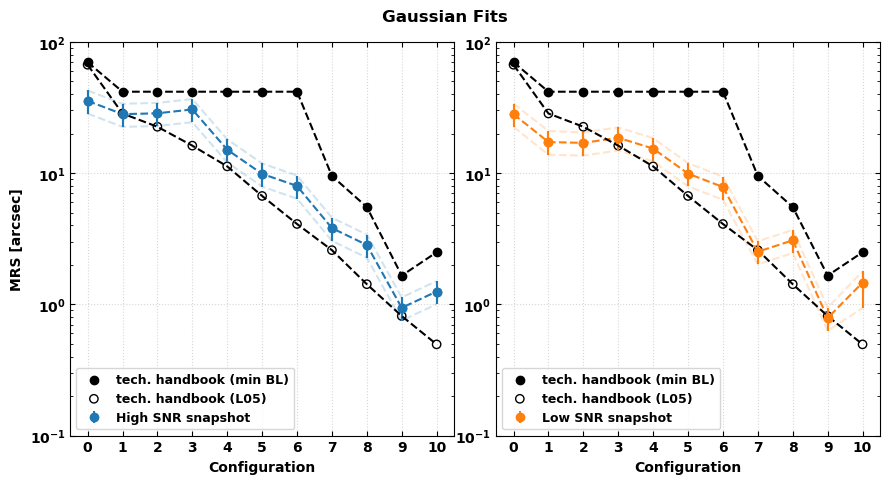

In [48]:
fig1, ax = plt.subplots(1, 2, figsize=(9,5))
ax = ax.flatten()

which_times_ = ['_6totaltime_comb', '_6totaltime_noise_comb']

for i, which_time in enumerate(list(which_times_)):
    
    table = tables_mrs[which_time] 

    conf = np.array(table['conf_'])
    r_mask10 = np.array(table['ratio_mask10_50percent'])
    r_fit = np.array(table['ratio_fit_50percent'])
    r_fitl = np.array(table['ratio_fiterrl_50percent'])
    r_fith = np.array(table['ratio_fiterrh_50percent'])

    # Make label 
    time = which_time.split('totaltime')[0].split('_')[-1]
    if time == '6': 
        time = 'snapshot'
    else: 
        time = '10 hours'
    label = which_time.split('totaltime')[-1]
    label = label.replace('_', '')
    label = label.replace('comb', '')
    if 'noise' in label:
        label=label.replace('noise', 'Low SNR')
    else: 
        label='%sHigh SNR' %(label)
    #

    yerr = np.abs(np.array([r_fit-r_fitl, r_fit-r_fith]))
    threshold = r_fit * 0.2
    yerr[0][yerr[0] < threshold] = threshold[yerr[0] < threshold]
    yerr[1][yerr[1] < threshold] = threshold[yerr[1] < threshold]
    
    ax[i].errorbar(conf, r_fit, yerr=yerr, fmt='o', label='%s %s' %(label, time), color='C%i'%i)
    ax[i].plot(conf, r_fit, ls='--', c='C%i'%i)
    ax[i].errorbar(conf, r_fit, yerr=r_fit*0.2, fmt='o', color='C%i'%i)

    ax[i].plot(conf, r_fit-yerr[0], ls='--', c='C%i'%i, alpha=0.2)
    ax[i].plot(conf, r_fit+yerr[1], ls='--', c='C%i'%i, alpha=0.2)

    ax[i].plot(mrs_conf, mrs_size, c='k', ls='--')
    ax[i].scatter(mrs_conf, mrs_size, c='k', label='tech. handbook (min BL)')

    ax[i].plot(mrs_conf, mrs_size5, c='k', ls='--')
    ax[i].scatter(mrs_conf, mrs_size5, ec='k', fc='none', label='tech. handbook (L05)')


for ax_ in ax: 
    ax_.grid(True, ls=':', alpha=0.5)
    ax_.xaxis.set_major_locator(MultipleLocator(1))
    ax_.yaxis.set_minor_locator(MultipleLocator(1))
    ax_.set_ylim([-1,30])
    ax_.set_xlim([-0.5,10.5])
    ax_.legend(loc='upper right', fontsize=9)

# ax[0].text(0.05, 0.12, 'Gaussian', ha='left', transform=ax[0].transAxes, fontsize=11)
# ax[0].text(0.05, 0.05, 'Fit', ha='left', transform=ax[0].transAxes, fontsize=9)
fig1.suptitle('Gaussian Fits', fontweight='bold', y=0.96)

ax[0].set_ylabel('MRS [arcsec]')
# ax[1].set_ylabel('MRS [arcsec]')

for ax_ in ax: 
    ax_.set_yscale('log')
    ax_.set_ylim([0.1, 1e2])
    ax_.legend(loc='lower left', fontsize=9)

for i in [0,1]:
    ax[i].set_xlabel('Configuration')

fig1.tight_layout(w_pad=0.1, h_pad=0.1)
fig1.savefig(f'./../figs/mrs_fit_all_{which}_6only.pdf', dpi=300, bbox_inches='tight', transparent=False)
fig1.savefig(f'./../figs/mrs_fit_all_{which}_6only.png', dpi=300, bbox_inches='tight', transparent=False)

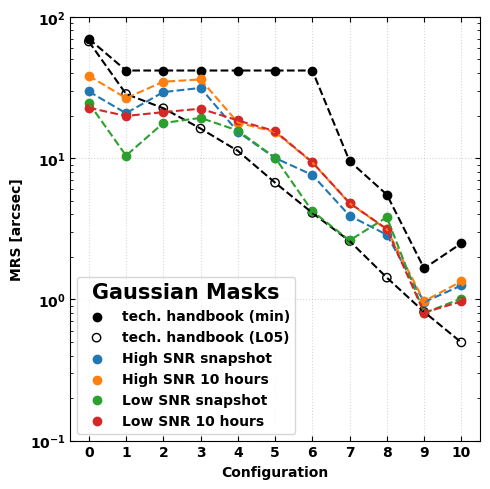

In [39]:
fig1, ax1 = plt.subplots(1,1, figsize=(5, 5))

ax1.plot(mrs_conf, mrs_size, c='k', ls='--')
ax1.scatter(mrs_conf, mrs_size, c='k', label='tech. handbook (min)')

ax1.plot(mrs_conf, mrs_size5, c='k', ls='--')
ax1.scatter(mrs_conf, mrs_size5, ec='k', fc='none', label='tech. handbook (L05)')

for i, which_time in enumerate(list(which_times)):

    table = tables_mrs[which_time] 

    conf = np.array(table['conf_'])
    r_mask10 = np.array(table['ratio_mask10_50percent'])
    r_fit = np.array(table['ratio_fit_50percent'])
    r_fitl = np.array(table['ratio_fiterrl_50percent'])
    r_fith = np.array(table['ratio_fiterrh_50percent'])

    # Make label 
    time = which_time.split('totaltime')[0].split('_')[-1]
    if time == '6': 
        time = 'snapshot'
    else: 
        time = '10 hours'
    label = which_time.split('totaltime')[-1]
    label = label.replace('_', '')
    label = label.replace('comb', '')
    if 'noise' in label:
        label=label.replace('noise', 'Low SNR')
    else: 
        label='%sHigh SNR' %(label)
    #
    ax1.plot(conf, r_mask10, ls='--', color='C%i'%i)
    ax1.scatter(conf, r_mask10, label='%s %s' %(label, time), color='C%i'%i)

ax1.set_xlabel('Configuration')
ax1.set_ylabel('MRS [arcsec]')
ax1.grid(True, ls=':', alpha=0.5)
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(1))

ax1.set_yscale('log')
ax1.set_ylim([0.1, 1e2])
ax1.legend(loc='lower left', fontsize=10, title='Gaussian Masks', title_fontsize=15)
fig1.tight_layout()
fig1.savefig(f'./../figs/mrs_mask_{which}.pdf', dpi=300, bbox_inches='tight', transparent=False)
fig1.savefig(f'./../figs/mrs_mask_{which}.png', dpi=300, bbox_inches='tight', transparent=False)

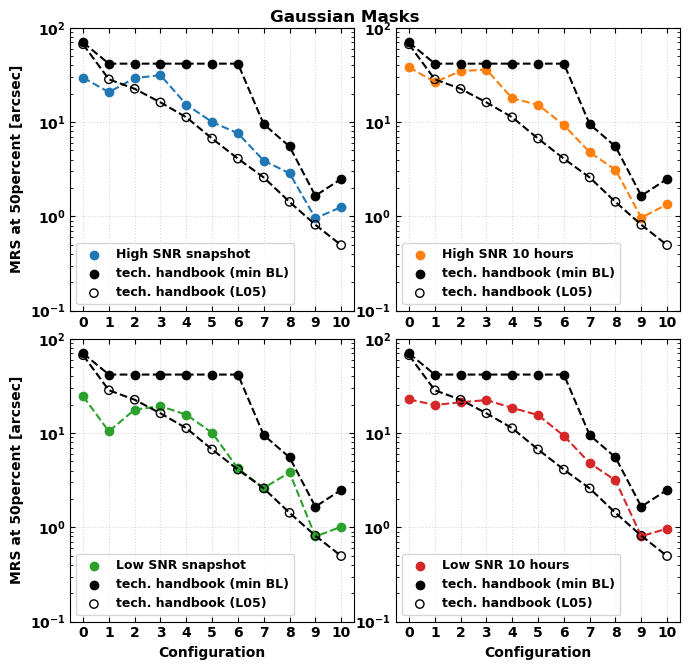

In [40]:
fig1, ax = plt.subplots(2, 2, figsize=(7,7))
ax = ax.flatten()

for i, which_time in enumerate(list(which_times)):
    
    table = tables_mrs[which_time] 

    conf = np.array(table['conf_'])
    r_mask10 = np.array(table['ratio_mask10_50percent'])
    r_fit = np.array(table['ratio_fit_50percent'])
    r_fitl = np.array(table['ratio_fiterrl_50percent'])
    r_fith = np.array(table['ratio_fiterrh_50percent'])

    # Make label 
    time = which_time.split('totaltime')[0].split('_')[-1]
    if time == '6': 
        time = 'snapshot'
    else: 
        time = '10 hours'
    label = which_time.split('totaltime')[-1]
    label = label.replace('_', '')
    label = label.replace('comb', '')
    if 'noise' in label:
        label=label.replace('noise', 'Low SNR')
    else: 
        label='%sHigh SNR' %(label)
    #

    ax[i].plot(conf, r_mask10, ls='--', color='C%i'%i)
    ax[i].scatter(conf, r_mask10, label='%s %s' %(label, time), color='C%i'%i)

    ax[i].plot(mrs_conf, mrs_size, c='k', ls='--')
    ax[i].scatter(mrs_conf, mrs_size, c='k', label='tech. handbook (min BL)')

    ax[i].plot(mrs_conf, mrs_size5, c='k', ls='--')
    ax[i].scatter(mrs_conf, mrs_size5, ec='k', fc='none', label='tech. handbook (L05)')

for ax_ in ax: 
    ax_.grid(True, ls=':', alpha=0.5)
    ax_.xaxis.set_major_locator(MultipleLocator(1))
    ax_.yaxis.set_minor_locator(MultipleLocator(1))
    ax_.set_ylim([-1,30])
    ax_.set_xlim([-0.5,10.5])
    ax_.legend(loc='upper right', fontsize=9)

fig1.suptitle('Gaussian Masks', fontweight='bold', y=0.95)

ax[0].set_ylabel('MRS at 50percent [arcsec]')
ax[2].set_ylabel('MRS at 50percent [arcsec]')

for i in [2,3]:
    ax[i].set_xlabel('Configuration')

for ax_ in ax: 
    ax_.set_yscale('log')
    ax_.set_ylim([0.1, 1e2])
    ax_.legend(loc='lower left', fontsize=9)

fig1.tight_layout(w_pad=0.1, h_pad=0.1)
fig1.savefig(f'./../figs/mrs_maks_all_{which}.pdf', dpi=300, bbox_inches='tight', transparent=False)
fig1.savefig(f'./../figs/mrs_mask_all_{which}.png', dpi=300, bbox_inches='tight', transparent=False)